# Making Gamma Temp diff dependent


Okay everything is gone...

$\gamma = \gamma_0(1-\Delta T)$

But basically the plan was to update gamma at every timestep in the code instead of analytically fixing the solution.. The analytical solution is too difficult as it involves a system of inhomogenoeu, nonlinear, first-order ODEs. 

So instead, we (naively) thought, why not just stick with the old system of equations where gamma was constant, but update it every time step according to:

    gamma = gamma_0 (1 - kappa * deltaT)

where kappa is a parameter we have to fix. Constant gamma corresponds to kappa = 0.


Then we were updating the code to do so, but struggling because of the strange self.parameter dictionaries. Also, printing stuff along the way crashed everything and we lost this whole doc:/
A lot of things needed to change, and for every change the import cell below must be run. 



In [1]:
import json
import numpy as np
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sty
import random
import pandas as pd
from tqdm import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

import matplotlib.pyplot as plt
import json

In [2]:
for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
    scm = TwoLayerModel(
        extforce= 4*np.ones(751),
        exttime=np.arange(1750,2501),
        tbeg=1750,
        tend=2501,
        lamg=4.0/3.0,
        t2x=None,
        eff=1.29,
        cmix=6,
        cdeep=75,
        gamma_2l=0.7,
        kappa=0.31, #THIS IS THE desired addition
        outtime=np.arange(1750.5,2501),
        dt=3
    )
        
out1 = scm.run()

100%|██████████| 1000/1000 [00:00<00:00, 24034.34it/s]


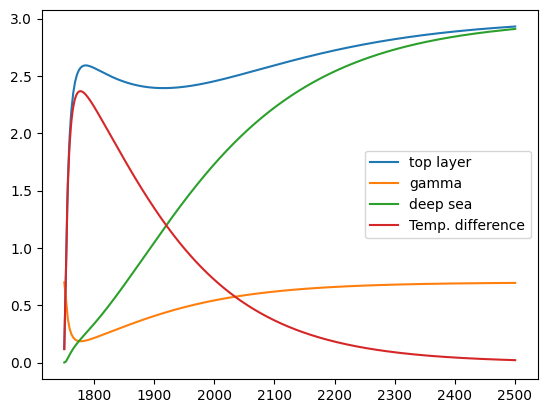

In [3]:
plt.plot(out1.time, out1.tg, label = "top layer")
plt.plot(out1.time[::3], out1.gammas, label = "gamma")
plt.plot(out1.time, out1.tlev[:,1], label="deep sea")
plt.plot(out1.time, (out1.tg-out1.tlev[:,1]), label="Temp. difference")
plt.legend()

### Is this doing what we expect it to? Yes! :)

When the temp difference is large and positive, we expect stability to increase, so for gamma to decrease. This is indeed happening. If the temp difference approaches zero, we expect gamma to go back to its default value, which it does indeed do.



In [4]:
#comparing above to when kappa = 0

for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
    scm = TwoLayerModel(
        extforce= 4*np.ones(751),
        exttime=np.arange(1750,2501),
        tbeg=1750,
        tend=2501,
        lamg=4.0/3.0,
        t2x=None,
        eff=1.29,
        cmix=6,
        cdeep=75,
        gamma_2l=0.7,
        kappa=0, #THIS IS THE desired addition
        outtime=np.arange(1750.5,2501),
        dt=3
    )
        
out2 = scm.run()

100%|██████████| 1000/1000 [00:00<00:00, 35486.31it/s]


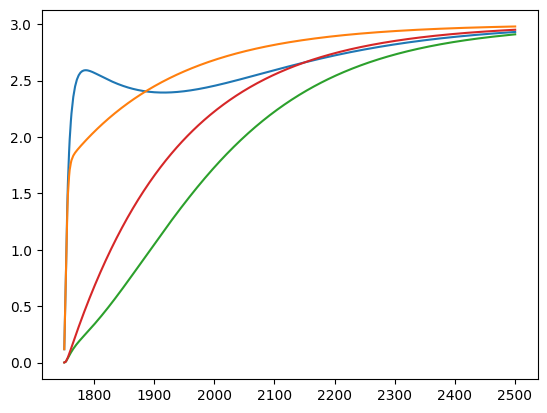

In [5]:
plt.plot(out1.time, out1.tg)
plt.plot(out2.time, out2.tg)
plt.plot(out1.time, out1.tlev[:,1])
plt.plot(out2.time, out2.tlev[:,1])
#SAME...
#print(out1.tlev[:,1] - out2.tlev[:,1])